In [1]:
import torch

from detectron2 import model_zoo
from detectron2.modeling import build_model
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.config import get_cfg
import detectron2.config

# import some common libraries
import numpy as np
import os
import json
import cv2
import random
import matplotlib.pyplot as plt
import csv

## Load the dataset


In [2]:
# Select your GPU if available
if torch.cuda.is_available():
    print(f'CUDAs available: {torch.cuda.device_count()}')
    torch.cuda.set_device(1) #Set default GPU here
else:
    print("CUDA is not available")

CUDAs available: 3


In [3]:
# Hyperparameters
checkpoint_name = "model_0009999.pth"
backbone = 101
num_classes = 19
filename = 'Rooftop Identification Model'

# Datasets
rootFolder = './Dataset'

# Train
trainDataDir = rootFolder + '/augmented_with_rotations'
trainAnnFile = rootFolder + '/augmented_with_rotations/augmented_train.json'
trainRoofAnnFile =  rootFolder + '/augmented_with_rotations/roof_train.json'
trainSsAnnFile =  rootFolder + '/augmented_with_rotations/ss_train.json'

# Test
testDataDir = rootFolder + '/test/images'
testAnnFile = rootFolder + '/test/test.json'
testAnnFile = rootFolder + '/test/annotations_test_filtered_average_sample_group.json'
testRoofAnnFile =  rootFolder + '/test/roof_test.json'
testSsAnnFile =  rootFolder + '/test/ss_test.json'

# Val
valDataDir = rootFolder + '/val/images'
valAnnFile = rootFolder + '/val/val.json'
valRoofAnnFile =  rootFolder + '/val/roof_val.json'
valSsAnnFile =  rootFolder + '/val/ss_val.json'

# Output directory
output_dir = f'./output_models/{filename}'

print(f'Train file: {trainAnnFile}')
print(f'Validation File: {valAnnFile}')
print(f'Output Directory: {output_dir}')

csv_filename = os.path.join(output_dir,'metrics_report.csv')

Train file: ./dataset_filtered (incomplete)/342_Set/augmented_with_rotations/augmented_train.json
Validation File: ./dataset_filtered (incomplete)/342_Set/val/val.json
Output Directory: ./output_models/X12-SAR-0.01-D-101-100000/342_Set


In [4]:
register_coco_instances("train_dataset", {}, trainAnnFile, trainDataDir)
train_dataset = DatasetCatalog.get("train_dataset")

register_coco_instances("val_dataset", {}, valAnnFile, valDataDir)
val_dataset = DatasetCatalog.get("val_dataset")

register_coco_instances("test_dataset", {}, testAnnFile, testDataDir)
test_dataset = DatasetCatalog.get("test_dataset")

metadata=MetadataCatalog.get("train_dataset")

Filtered out 82 instances without valid segmentation. There might be issues in your dataset generation process.  Please check https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html carefully


In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(f"COCO-InstanceSegmentation/mask_rcnn_R_{backbone}_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_dataset",)
cfg.DATASETS.TEST = ("test_dataset")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes   
cfg.OUTPUT_DIR = output_dir

# Load the weights from training
cfg.MODEL.WEIGHTS = os.path.join(output_dir, checkpoint_name)  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
cfg.MODEL.RPN.NMS_THRESH = 0.5

predictor = DefaultPredictor(cfg)

In [6]:
def display(filename, display_list):
#   plt.figure(figsize=(15, 5))
  plt.figure(figsize=(40, 40))


  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    
    plt.figure(figsize=(40,40))
    
    plt.axis('off')
  
  print(filename)
  filename = os.path.join(cfg.OUTPUT_DIR, filename.split('/')[-1])
  print(filename)
  plt.savefig(filename)
    
  plt.show()

### Metrics Calculation

In [12]:
evaluator = COCOEvaluator("test_dataset", output_dir=os.path.join(cfg.OUTPUT_DIR,'test_scores'))
val_loader = build_detection_test_loader(cfg, "test_dataset")
metric_dict = inference_on_dataset(predictor.model, val_loader, evaluator)

print('Bbox AP: ', metric_dict['bbox']['AP'])
print('Segmentation AP: ', metric_dict['segm']['AP'])

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.772
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.140
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.391
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.428
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.519
 Average Recall     (AR) @[ IoU=0.50:0.

In [13]:
metric_dict

OrderedDict([('bbox',
              {'AP': 37.3283335499534,
               'AP50': 48.3428566388369,
               'AP75': 42.3256754925773,
               'APs': 29.816291801077583,
               'APm': 43.932979096526026,
               'APl': 77.19083872672982,
               'AP-Superstructure': nan,
               'AP-FLAT': nan,
               'AP-WNW': 47.433449008580006,
               'AP-N': 29.691803766842856,
               'AP-NNW': 43.939939878110614,
               'AP-NW': 26.593277748827514,
               'AP-W': 24.712871287128714,
               'AP-WSW': 46.11034327637947,
               'AP-SW': 13.131541725601132,
               'AP-SSW': nan,
               'AP-S': 50.81367944486757,
               'AP-SSE': 51.41702875799703,
               'AP-SE': 46.699017154462695,
               'AP-ESE': 52.52091827098797,
               'AP-E': 18.11221122112211,
               'AP-ENE': 40.75502160178424,
               'AP-NE': 30.665566556655666,
               'AP

In [14]:
with open(csv_filename, 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, metric_dict['bbox'].keys())
    w.writeheader()
    w.writerow(metric_dict['bbox'])
    w.writerow(metric_dict['segm'])

In [15]:
#Validation Loss
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

./output_models/X12-SAR-0.01-D-101-100000/342_Set/model_loss.png


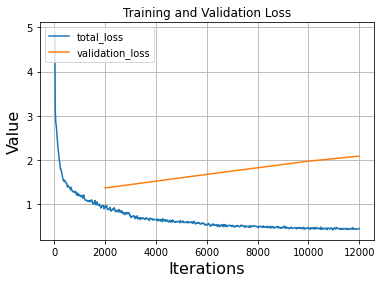

./output_models/X12-SAR-0.01-D-101-100000/342_Set/model_lr.png


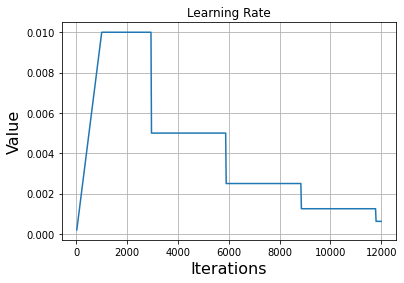

In [16]:
metrics = load_json_arr(output_dir + '/metrics.json')
metrics = [x for x in metrics if x['iteration'] < 12000]
# TRAINING AND VALIDATION LOSS
plt.plot(
    [x['iteration'] for x in metrics if 'total_loss' in x],
    [x['total_loss'] for x in metrics if 'total_loss' in x])
plt.legend(['training_loss'], loc='upper left')
plt_title = 'Training Loss'

plt.plot(
    [x['iteration'] for x in metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in metrics if 'validation_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt_title = 'Training and Validation Loss'
    
plt.grid(b=True)
plt.title(plt_title)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Value', fontsize=16)

loss_filename = os.path.join(cfg.OUTPUT_DIR, 'model_loss.png')
print(loss_filename)
plt.savefig(loss_filename)
plt.show()

# LEARNING RATE
plt.plot(
    [x['iteration'] for x in metrics if 'lr' in x],
    [x['lr'] for x in metrics if 'lr' in x])
plt.grid(b=True)
plt.title('Learning Rate')
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Value', fontsize=16)

loss_filename = os.path.join(cfg.OUTPUT_DIR, 'model_lr.png')
print(loss_filename)
plt.savefig(loss_filename)
plt.show()